In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from torch import device, cuda
from torch.optim import Adam
from torch import nn
import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision

from tqdm import trange, tqdm

from ViT import MyViT

In [2]:
# Defining model and training options
mydevice = device("cuda" if cuda.is_available() else "cpu")
print("Using device: ", device, f"({cuda.get_device_name(device)})" if cuda.is_available() else "")

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))]) 

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform) #60,000 images
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform) #10,000 images

train_loader = DataLoader(train_set, shuffle=True, batch_size=128) #batch size of 128, 469 batches
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)  #batch size of 128, 79 batches

classes = train_set.classes

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_with_sinconsine')

Using device:  <class 'torch.device'> (NVIDIA GeForce RTX 3060 Laptop GPU)


In [3]:
model = MyViT(
    num_classes=10,
    img_size=(28, 28),
    num_channels = 1,
    patch_size=(4, 4),
    dim=4*4, # final resolution for pixels in each patch (embedded vectors (tokens) dim d)
    depth = 2, # Number of transformer blocks (MSA+MLP)
    dim_head = 16, # dimension of the heads in the MSA (dim T) -> matrixes Q, K, V in Transformer are Txd dimensions
    heads = 8, # number of heads in the MSA
    mlp_dim = 2, # dimension of the hidden layer in the MLP
    dropout = 0.1, # dropout rate for layers in Transformer blocks
    embedding_dropout = 0.1 # dropout rate for the tokens+class token+positional encoding before the transformer
  ).to(mydevice)

N_EPOCHS = 5
LR = 0.005

In [4]:
next(model.parameters()).is_cuda

True

MyViT(
  (patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoderBlock(
    (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (blocks): ModuleList(
      (0-1): 2 x ModuleList(
        (0): MSA(
          (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (soft_max_attend): Sequential(
            (0): Softmax(dim=-1)
            (1): Dropout(p=0.1, inplace=False)
          )
          (to_qkv): Linear(in_features=16, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=16, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedFo

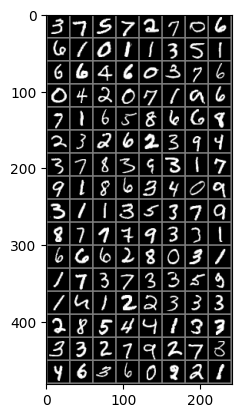

In [5]:
import matplotlib.pyplot as plt
import numpy as np
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.cpu().mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images using our helper function
matplotlib_imshow(img_grid)
# Write the generated image to tensorboard
writer.add_image('four_mnist_images', img_grid)

writer.add_graph(model.cpu(), images)
#writer.close()

model.to(mydevice)

In [8]:
# Functions to log training images in tensorboard
def images_to_probs(model, images):
    '''
    Returns the predicted class and probabilites of the image belonging to each of the classes 
    from the network output
    '''
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(model, images, labels):
    '''
    Returns a plot using the network, along with images
    and labels from a batch, that shows the network's class prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function defined above.
    '''
    preds, probs = images_to_probs(model, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(4,4))
    
    for idx in np.arange(4):
        ax = fig.add_subplot(4, 1.2, idx+1, xticks=[], yticks=[])
        fig.tight_layout()
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"),loc="center",pad=5,fontsize="medium")
    return fig

In [9]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for iteration, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False)):
        inputs, labels = batch
        inputs, labels = inputs.to(mydevice), labels.to(mydevice)
        y_hat = model(inputs)
        loss = criterion(y_hat, labels)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration % 1000 == 999:    # every thousandth mini-batch
            print("[Epoch %d, Iteration %5d]" % (epoch+1, iteration+1))
            # log the training loss
            writer.add_scalar('Training loss',
                            train_loss / 1000,
                            epoch * len(train_loader) + iteration)

            # log the plot showing the model's predictions on a  sample of mini-batch using our helper function
            writer.add_figure('Predictions vs Actuals',
                            plot_classes_preds(model, inputs, labels),
                            iteration)

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")


Training:  20%|██        | 1/5 [00:14<00:58, 14.50s/it]

Epoch 1/5 loss: 1.00


Training:  40%|████      | 2/5 [00:28<00:42, 14.20s/it]

Epoch 2/5 loss: 0.42


Training:  60%|██████    | 3/5 [00:42<00:28, 14.10s/it]

Epoch 3/5 loss: 0.34


Training:  80%|████████  | 4/5 [00:56<00:14, 14.12s/it]

Epoch 4/5 loss: 0.30


Training: 100%|██████████| 5/5 [01:10<00:00, 14.11s/it]

Epoch 5/5 loss: 0.29


In [10]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(mydevice), y.to(mydevice)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 79/79 [00:02<00:00, 26.84it/s]

Test loss: 0.25
Test accuracy: 91.66%
